## Generate diagnostic plots

Show gas/stellar surface densities, velocities, and velocity dispersions. 

In [1]:
import os
from glob import glob
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from time import process_time 
from copy import copy
import multiprocessing as mp


In [ ]:
data_dir = '/home/bottrell/scratch/Fire_Kinematics/LOSVD'
sim_tag = 'G2G3_e'
sub_tag = 'orbit_1'
camera = 'i0'
ptype = 'gas'
snapID = 270

losvd_name = '{}/{}/{}/kinemetry_datacube_{}-{}_{:04d}_{}_{}.fits'.format(data_dir,sim_tag,sub_tag,sim_tag,sub_tag,snapID,ptype,camera)
if os.access(losvd_name,0): print('File found.')

losvd_head = fits.getheader(losvd_name)
losvd_data = fits.getdata(losvd_name)

### Create single diagnostic plot

In [ ]:
def add_colorbar(im,ax,label,colour='white'):
    axin = ax.inset_axes(
            [0.05,0.05, 0.9, 0.025], transform=ax.transAxes)
    cbar = plt.colorbar(im, cax=axin, orientation='horizontal')
    cbar.ax.tick_params(color=colour, labelcolor=colour,direction='in',labeltop=1,
                        labelbottom=0,top=1,bottom=0, width=1, labelsize=14)
    cbar.set_label(label, color=colour, size=12)
    cbar.ax.xaxis.set_label_position('top') 
    cbar.outline.set_edgecolor(colour)
    cbar.outline.set_linewidth(1.5)

def generate_maps(losvd_name):
    if not os.access(losvd_name,0):
        print('LOSVD file not found')
    else:
        losvd_head = fits.getheader(losvd_name)
        losvd_data = fits.getdata(losvd_name)
        losvd_shape = losvd_data.shape
        vlim = losvd_head['VLIM'] # km/s
        delv = losvd_head['DELV'] # km/s
        fov = losvd_head['FOVSIZE']/1000. # kpc
        vel = np.linspace(-vlim,vlim,losvd_shape[-1],endpoint=False)+delv/2.
        sum_wi = np.nansum(losvd_data,axis=-1)
        sum_wivi = np.nansum(losvd_data*vel,axis=-1)
        vbar = sum_wivi/sum_wi
        Nprime = np.nansum(losvd_data>0,axis=-1)
        vstd = np.nansum(losvd_data*(vel-vbar[...,np.newaxis])**2,axis=-1)
        vstd /= (Nprime-1)/Nprime*sum_wi
        vstd = np.sqrt(vstd)
        losvd_maps = np.array([sum_wi,vbar,vstd])
        return losvd_maps

def generate_figure(sim_tag,sub_tag,camera,snapID):
    
    data_dir = '/home/bottrell/scratch/Fire_Kinematics/LOSVD'
    
    fig,axarr = plt.subplots(2,3,figsize=(15,10))
    fig.subplots_adjust(wspace=0.05,hspace=0.05)
    axarr = axarr.flat

    for ax in axarr:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        for spine in ['top','left','right','bottom']:
            ax.spines[spine].set_linewidth(4)

    ptype = 'gas'
    losvd_name = '{}/{}/{}/kinemetry_datacube_{}-{}_{:04d}_{}_{}.fits'.format(data_dir,sim_tag,sub_tag,sim_tag,sub_tag,snapID,ptype,camera)
    maps = generate_maps(losvd_name)

    ax = axarr[0]
    cmap = copy(plt.cm.inferno)
    cmap.set_bad('black', 1.0)
    im = ax.imshow(np.log10(maps[0]),vmin=3,vmax=7,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Gas surface density, $\log\;\Sigma_{\mathrm{gas}}$ [M$_{\odot}}$/kpc$^2$]'
    add_colorbar(im,ax,label,colour=cbar_colour)

    ax = axarr[1]
    cmap = copy(plt.cm.jet)
    cmap.set_bad('black', 1.0)
    im = ax.imshow(maps[1],vmin=-150,vmax=150,cmap=cmap,origin='lower',aspect='auto',interpolation='none')
    cbar_colour = 'white'
    label = r'Gas velocity, $V_{\mathrm{LOS,gas}}$ [km/s]'
    add_colorbar(im,ax,label,colour=cbar_colour)

    ax = axarr[2]
    cmap = copy(plt.cm.Blues_r)
    cmap.set_bad('black', 1.0)
    im = ax.imshow(maps[2],vmin=0,vmax=150,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Gas vel. dispersion, $\sigma_{\mathrm{LOS,gas}}$ [km/s]'
    add_colorbar(im,ax,label,colour=cbar_colour)

    ptype = 'stars'
    losvd_name = '{}/{}/{}/kinemetry_datacube_{}-{}_{:04d}_{}_{}.fits'.format(data_dir,sim_tag,sub_tag,sim_tag,sub_tag,snapID,ptype,camera)
    maps = generate_maps(losvd_name)
    mask = np.log10(maps[0])<4

    ax = axarr[3]
    cmap = copy(plt.cm.bone)
    cmap.set_bad('black', 1.0)
    im = ax.imshow(np.log10(maps[0]),vmin=3,vmax=7,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Stellar surface density, $\log\;\Sigma_{\star}$ [M$_{\odot}}$/kpc$^2$]'
    add_colorbar(im,ax,label,colour=cbar_colour)

    maps[:,mask] = np.nan

    ax = axarr[4]
    cmap = copy(plt.cm.jet)
    cmap.set_bad('black', 1.0)
    im = ax.imshow(maps[1],vmin=-100,vmax=100,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Stellar velocity, $V_{\mathrm{LOS,\star}}$ [km/s]'
    add_colorbar(im,ax,label,colour=cbar_colour)

    ax = axarr[5]
    cmap = copy(plt.cm.Blues_r)
    cmap.set_bad('black', 1.0)
    im = ax.imshow(maps[2],vmin=0,vmax=150,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Stellar vel. dispersion, $\sigma_{\mathrm{LOS,\star}}$ [km/s]'
    add_colorbar(im,ax,label,colour=cbar_colour)
    
    return fig

sim_tag = 'G2G3_e'
sub_tag = 'orbit_1'
camera = 'i0'
snapID = 279

fig = generate_figure(sim_tag,sub_tag,camera,snapID)

save_dir = '/home/bottrell/scratch/Fire_Kinematics/Figures/Movies'
fig.savefig('{}/Diagnostic_{}_{}_{:04d}_{}_LowRes.png'.format(save_dir,sim_tag,sub_tag,snapID,camera),
            bbox_inches='tight',dpi=128)

### Create all diagnostic plots for given merger w/ multiprocessing

In [ ]:
import os,imageio
from glob import glob
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from time import process_time 
from copy import copy
import multiprocessing as mp

def add_colorbar(im,ax,label,colour='white'):
    axin = ax.inset_axes(
            [0.05,0.05, 0.9, 0.025], transform=ax.transAxes)
    cbar = plt.colorbar(im, cax=axin, orientation='horizontal')
    cbar.ax.tick_params(color=colour, labelcolor=colour,direction='in',labeltop=1,
                        labelbottom=0,top=1,bottom=0, width=1, labelsize=14)
    cbar.set_label(label, color=colour, size=12)
    cbar.ax.xaxis.set_label_position('top') 
    cbar.outline.set_edgecolor(colour)
    cbar.outline.set_linewidth(1.5)

def generate_maps(losvd_name):
    if not os.access(losvd_name,0):
        print('LOSVD file not found')
    else:
        losvd_head = fits.getheader(losvd_name)
        losvd_data = fits.getdata(losvd_name)
        losvd_shape = losvd_data.shape
        vlim = losvd_head['VLIM'] # km/s
        delv = losvd_head['DELV'] # km/s
        fov = losvd_head['FOVSIZE']/1000. # kpc
        vel = np.linspace(-vlim,vlim,losvd_shape[-1],endpoint=False)+delv/2.
        sum_wi = np.nansum(losvd_data,axis=-1)
        sum_wivi = np.nansum(losvd_data*vel,axis=-1)
        vbar = sum_wivi/sum_wi
        Nprime = np.nansum(losvd_data>0,axis=-1)
        vstd = np.nansum(losvd_data*(vel-vbar[...,np.newaxis])**2,axis=-1)
        vstd /= (Nprime-1)/Nprime*sum_wi
        vstd = np.sqrt(vstd)
        losvd_maps = np.array([sum_wi,vbar,vstd])
        return losvd_maps

def generate_figure(sim_tag,sub_tag,camera,snapID):
    
    data_dir = '/home/bottrell/scratch/Fire_Kinematics/LOSVD'
    
    fig,axarr = plt.subplots(2,3,figsize=(15,10))
    fig.subplots_adjust(wspace=0.05,hspace=0.05)
    axarr = axarr.flat

    for ax in axarr:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        for spine in ['top','left','right','bottom']:
            ax.spines[spine].set_linewidth(4)

    ptype = 'gas'
    losvd_name = '{}/{}/{}/kinemetry_datacube_{}-{}_{:04d}_{}_{}.fits'.format(data_dir,sim_tag,sub_tag,sim_tag,sub_tag,snapID,ptype,camera)
    maps = generate_maps(losvd_name)

    ax = axarr[0]
    cmap = copy(plt.cm.inferno)
    cmap.set_bad('black', 1.0)
    im = ax.imshow(np.log10(maps[0]),vmin=3,vmax=7,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Gas surface density, $\log\;\Sigma_{\mathrm{gas}}$ [M$_{\odot}}$/kpc$^2$]'
    add_colorbar(im,ax,label,colour=cbar_colour)

    ax = axarr[1]
    cmap = copy(plt.cm.jet)
    cmap.set_bad('black', 1.0)
    im = ax.imshow(maps[1],vmin=-150,vmax=150,cmap=cmap,origin='lower',aspect='auto',interpolation='none')
    cbar_colour = 'white'
    label = r'Gas velocity, $V_{\mathrm{LOS,gas}}$ [km/s]'
    add_colorbar(im,ax,label,colour=cbar_colour)

    ax = axarr[2]
    cmap = copy(plt.cm.Blues_r)
    cmap.set_bad('black', 1.0)
    im = ax.imshow(maps[2],vmin=0,vmax=150,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Gas vel. dispersion, $\sigma_{\mathrm{LOS,gas}}$ [km/s]'
    add_colorbar(im,ax,label,colour=cbar_colour)

    ptype = 'stars'
    losvd_name = '{}/{}/{}/kinemetry_datacube_{}-{}_{:04d}_{}_{}.fits'.format(data_dir,sim_tag,sub_tag,sim_tag,sub_tag,snapID,ptype,camera)
    maps = generate_maps(losvd_name)
    mask = np.log10(maps[0])<4

    ax = axarr[3]
    cmap = copy(plt.cm.bone)
    cmap.set_bad('black', 1.0)
    im = ax.imshow(np.log10(maps[0]),vmin=3,vmax=7,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Stellar surface density, $\log\;\Sigma_{\star}$ [M$_{\odot}}$/kpc$^2$]'
    add_colorbar(im,ax,label,colour=cbar_colour)

    maps[:,mask] = np.nan

    ax = axarr[4]
    cmap = copy(plt.cm.jet)
    cmap.set_bad('black', 1.0)
    im = ax.imshow(maps[1],vmin=-100,vmax=100,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Stellar velocity, $V_{\mathrm{LOS,\star}}$ [km/s]'
    add_colorbar(im,ax,label,colour=cbar_colour)

    ax = axarr[5]
    cmap = copy(plt.cm.Blues_r)
    cmap.set_bad('black', 1.0)
    im = ax.imshow(maps[2],vmin=0,vmax=150,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Stellar vel. dispersion, $\sigma_{\mathrm{LOS,\star}}$ [km/s]'
    add_colorbar(im,ax,label,colour=cbar_colour)
    
    return fig

def worker_wrapper(args):
    sim_tag,sub_tag,camera,snapID = args
    fig = generate_figure(sim_tag,sub_tag,camera,snapID)
    fig_name = '{}/Diagnostic_{}_{}_{:04d}_{}.png'.format(save_dir,sim_tag,sub_tag,snapID,camera)
    if not os.access(fig_name,0): 
        fig.savefig(fig_name,bbox_inches='tight',dpi=512)
    
losvd_dir = '/home/bottrell/scratch/Fire_Kinematics/LOSVD'
galsep_dir = '/home/bottrell/scratch/Fire/GalSep'
save_dir = '/home/bottrell/scratch/Fire_Kinematics/Figures/Movies'
sim_tag = 'G2G3_e'
sub_tag = 'orbit_1'
camera = 'i0'

galsep_pair = '{}/galsep_{}_{}_PairSnapIDs.npz'.format(galsep_dir,sim_tag,sub_tag)
galsep_post = '{}/galsep_{}_{}_PMSnapIDs.npz'.format(galsep_dir,sim_tag,sub_tag)
snapIDs_pair = np.load(galsep_pair)['snapID'].astype(int)
snapIDs_post = np.load(galsep_post)['snapID'].astype(int)
snapIDs = np.concatenate((snapIDs_pair,snapIDs_post))

argList = []
for snapID in snapIDs:
    argList += [(sim_tag,sub_tag,camera,snapID),]
    
SLURM_CPUS = mp.cpu_count()
pool = mp.Pool(SLURM_CPUS)
pool.map(worker_wrapper, argList)
pool.close()
pool.join()


### Combine diagnostic plots into movie

In [ ]:
import os,imageio
from glob import glob
import matplotlib
matplotlib.use('Agg')

losvd_dir = '/home/bottrell/scratch/Fire_Kinematics/LOSVD'
galsep_dir = '/home/bottrell/scratch/Fire/GalSep'
save_dir = '/home/bottrell/scratch/Fire_Kinematics/Figures/Movies'
sim_tag = 'G2G3_e'
sub_tag = 'orbit_1'
camera = 'i0'

file_names = list(sorted(glob('{}/Diagnostic_{}_{}_????_{}.png'.format(save_dir,sim_tag,sub_tag,camera))))
movie_name = '{}/Diagnostic_{}_{}_{}.mp4'.format(save_dir,sim_tag,sub_tag,camera)

with imageio.get_writer(movie_name) as writer:
    for file_name in file_names:
        image = imageio.imread(file_name)
        writer.append_data(image)

### Diagnostic plots for TNG100 galaxies

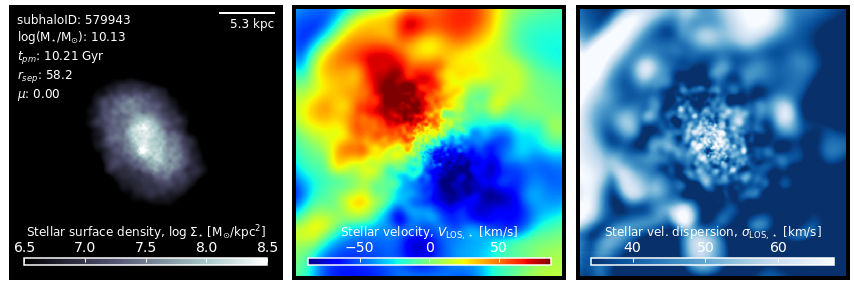

In [89]:
import os
from glob import glob
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from time import process_time 
from copy import copy
import multiprocessing as mp
import random
import pymysql



def add_colorbar(im,ax,label,colour='white'):
    axin = ax.inset_axes(
            [0.05,0.05, 0.9, 0.025], transform=ax.transAxes)
    cbar = plt.colorbar(im, cax=axin, orientation='horizontal')
    cbar.ax.tick_params(color=colour, labelcolor=colour,direction='in',labeltop=1,
                        labelbottom=0,top=1,bottom=0, width=1, labelsize=14)
    cbar.set_label(label, color=colour, size=12)
    cbar.ax.xaxis.set_label_position('top') 
    cbar.outline.set_edgecolor(colour)
    cbar.outline.set_linewidth(1.5)

def generate_figure(subhaloID,camera,snapID,use_sql=False,cnf_path=None):
    
    data_dir = '/home/bottrell/scratch/Merger_Kinematics/Moments/Illustris-TNG/TNG100-1/{:03}'.format(snapID)
    
    fig,axarr = plt.subplots(1,3,figsize=(15,5))
    fig.subplots_adjust(wspace=0.05,hspace=0.05)
    axarr = axarr.flat

    for ax in axarr:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        for spine in ['top','left','right','bottom']:
            ax.spines[spine].set_linewidth(4)


    __losvd_name__ = '{}/moments_TNG100-1_{}_{}_{}_{}__32.fits'
    
#     ptype = 'gas'
#     losvd_name = __losvd_name__.format(data_dir,snapID,subhaloID,ptype,camera)
#     maps = fits.getdata(losvd_name)

#     ax = axarr[0]
#     cmap = copy(plt.cm.inferno)
#     cmap.set_bad('black', 1.0)
#     im = ax.imshow(np.log10(maps[0]),vmin=3,vmax=7,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
#     cbar_colour = 'white'
#     label = r'Gas surface density, $\log\;\Sigma_{\mathrm{gas}}$ [M$_{\odot}}$/kpc$^2$]'
#     add_colorbar(im,ax,label,colour=cbar_colour)

#     ax = axarr[1]
#     cmap = copy(plt.cm.jet)
#     cmap.set_bad('black', 1.0)
#     im = ax.imshow(maps[1],vmin=-150,vmax=150,cmap=cmap,origin='lower',aspect='auto',interpolation='none')
#     cbar_colour = 'white'
#     label = r'Gas velocity, $V_{\mathrm{LOS,gas}}$ [km/s]'
#     add_colorbar(im,ax,label,colour=cbar_colour)

#     ax = axarr[2]
#     cmap = copy(plt.cm.Blues_r)
#     cmap.set_bad('black', 1.0)
#     im = ax.imshow(maps[2],vmin=0,vmax=150,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
#     cbar_colour = 'white'
#     label = r'Gas vel. dispersion, $\sigma_{\mathrm{LOS,gas}}$ [km/s]'
#     add_colorbar(im,ax,label,colour=cbar_colour)

    ptype = 'stars'
    losvd_name = __losvd_name__.format(data_dir,snapID,subhaloID,ptype,camera)
    maps = fits.getdata(losvd_name)
    header = fits.getheader(losvd_name)
    fov_kpc = header['FOV_KPC']
    npixels = header['NAXIS1']
    kpc_per_pixel = fov_kpc/npixels
    
    mask = np.log10(maps[0])
    #maps[:,mask<4.5] = np.nan
    
    if not use_sql:
        mstar = np.log10(np.nansum(maps[0]))
    else:
        db = pymysql.connect(host='lauca.phys.uvic.ca',user='cbottrell',
                             database='IllustrisTNG100_1',read_default_file=cnf_path)
        c = db.cursor()
        dbcmd = 'SELECT Mstar,Tpostmerger,rsep,MassRatio FROM Environment WHERE DB_ID="{}_{}"'.format(snapID,subhaloID)
        c.execute(dbcmd)
        data = np.array(c.fetchall())[0]
        c.close()
        db.close()
        mstar=data[0]
        tpost=data[1]
        rsep=data[2]
        mu=data[3]
        if rsep>300: rsep=999

    ax = axarr[0]
    cmap = copy(plt.cm.bone)
    cmap.set_bad('black', 1.0)
    vmin = np.around((4.5-np.log10(kpc_per_pixel**2))*2)/2
    vmax = np.around(np.nanpercentile(np.log10(maps[0]/kpc_per_pixel**2),99.9)*2)/2
    im = ax.imshow(np.log10(maps[0]/kpc_per_pixel**2),vmin=vmin,vmax=vmax,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Stellar surface density, $\log\;\Sigma_{\star}$ [M$_{\odot}}$/kpc$^2$]'
    add_colorbar(im,ax,label,colour=cbar_colour)
    
    txt = ['subhaloID: {}\n'.format(subhaloID),
           '$\log($M$_{{\star}}/$M$_{{\odot}}$): {:0.2f}\n'.format(mstar)]
    if use_sql:
        txt += ''.join(['$t_{{pm}}$: {:0.2f} Gyr\n'.format(tpost),
                        '$r_{{sep}}$: {:.1f}\n'.format(rsep),
                        '$\mu$: {:.2f}'.format(mu)])
    ax.text(0.025,0.975,''.join(txt),transform=ax.transAxes,ha='left',va='top',color='white',size=12)
    ax.axhline(y=0.975*maps.shape[1],xmax=0.975,xmin=0.775,c='white',lw=2)
    ax.text(0.975,0.96,'{:.1f} kpc'.format(fov_kpc/10),ha='right',va='top',color='white',size=12,transform=ax.transAxes)
    
    ax = axarr[1]
    cmap = copy(plt.cm.jet)
    cmap.set_bad('black', 1.0)
    vmap = copy(maps[1])
    vmap[mask<5]=np.nan
    vmin = np.abs(np.nanpercentile(vmap[192:-192,192:-192],1))
    vmax = np.abs(np.nanpercentile(vmap[192:-192,192:-192],99))
    vmax = (vmin+vmax)/2
    vmin = -vmax
    im = ax.imshow(maps[1],vmin=vmin,vmax=vmax,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Stellar velocity, $V_{\mathrm{LOS,\star}}$ [km/s]'
    add_colorbar(im,ax,label,colour=cbar_colour)

    ax = axarr[2]
    cmap = copy(plt.cm.Blues_r)
    cmap.set_bad('black', 1.0)
    smap = copy(maps[2])
    smap[mask<5]=np.nan
    smin = np.abs(np.nanpercentile(smap[192:-192,192:-192],1))
    smax = np.abs(np.nanpercentile(smap[192:-192,192:-192],99))
    im = ax.imshow(maps[2],vmin=smin,vmax=smax,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Stellar vel. dispersion, $\sigma_{\mathrm{LOS,\star}}$ [km/s]'
    add_colorbar(im,ax,label,colour=cbar_colour)
    return fig

snapID = 99
data_dir = '/home/bottrell/scratch/Merger_Kinematics/Moments/Illustris-TNG/TNG100-1/{:03}'.format(snapID)
filenames = list(sorted(glob('{}/moment*.fits'.format(data_dir))))

seed = 329402
seed = 1938109
random.seed(8290482)
filename = random.choice(filenames)
subhaloID = filename.split('_')[-5]
#subhaloID = 517812
camera = 'i3'

fig = generate_figure(subhaloID,camera,snapID,use_sql=True,cnf_path='/home/bottrell/.mysql/lauca.cnf')

save_dir = '/home/bottrell/scratch/Merger_Kinematics/Figures/TNG100-1/Diagnostic_Stellar_Ideal'
fig.savefig('{}/TNG100-1_Diagnostic_Stellar-Ideal_snapNum-{}_subhaloID-{}_camera-{}.pdf'.format(save_dir,snapID,subhaloID,camera),
             bbox_inches='tight')

### Make diagnostic plots for all TNG100-1 galaxies from snapshot 99

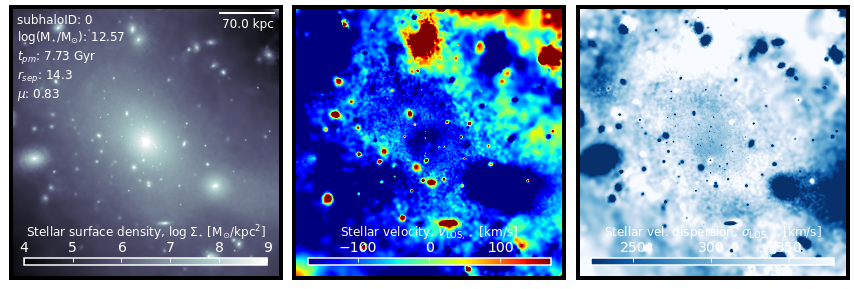

In [5]:
import os
from glob import glob
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from time import process_time 
from copy import copy
import multiprocessing as mp
import random
import pymysql



def add_colorbar(im,ax,label,colour='white'):
    axin = ax.inset_axes(
            [0.05,0.05, 0.9, 0.025], transform=ax.transAxes)
    cbar = plt.colorbar(im, cax=axin, orientation='horizontal')
    cbar.ax.tick_params(color=colour, labelcolor=colour,direction='in',labeltop=1,
                        labelbottom=0,top=1,bottom=0, width=1, labelsize=14)
    cbar.set_label(label, color=colour, size=12)
    cbar.ax.xaxis.set_label_position('top') 
    cbar.outline.set_edgecolor(colour)
    cbar.outline.set_linewidth(1.5)

def generate_figure(outfile,subhaloID,camera,snapID,use_sql=False,cnf_path=None):
    
    data_dir = '/home/bottrell/scratch/Merger_Kinematics/Moments/Illustris-TNG/TNG100-1/{:03}'.format(snapID)
    
    fig,axarr = plt.subplots(1,3,figsize=(15,5))
    fig.subplots_adjust(wspace=0.05,hspace=0.05)
    axarr = axarr.flat

    for ax in axarr:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        for spine in ['top','left','right','bottom']:
            ax.spines[spine].set_linewidth(4)

    __mapfile_name__ = '{}/moments_TNG100-1_{}_{}_{}_{}__32.fits'

    ptype = 'stars'
    mapfile_name = __mapfile_name__.format(data_dir,snapID,subhaloID,ptype,camera)
    maps = fits.getdata(mapfile_name)
    header = fits.getheader(mapfile_name)
    fov_kpc = header['FOV_KPC']
    npixels = header['NAXIS1']
    kpc_per_pixel = fov_kpc/npixels
    
    mask = np.log10(maps[0])
    #maps[:,mask<4.5] = np.nan
    
    if not use_sql:
        mstar = np.log10(np.nansum(maps[0]))
    else:
        db = pymysql.connect(host='lauca.phys.uvic.ca',user='cbottrell',
                             database='IllustrisTNG100_1',read_default_file=cnf_path)
        c = db.cursor()
        dbcmd = 'SELECT Mstar,Tpostmerger,rsep,MassRatio FROM Environment WHERE DB_ID="{}_{}"'.format(snapID,subhaloID)
        c.execute(dbcmd)
        data = np.array(c.fetchall())[0]
        c.close()
        db.close()
        mstar=data[0]
        tpost=data[1]
        rsep=data[2]
        mu=data[3]
        if rsep>300: rsep=999

    ax = axarr[0]
    cmap = copy(plt.cm.bone)
    cmap.set_bad('black', 1.0)
    vmin = np.around((4.5-np.log10(kpc_per_pixel**2))*2)/2
    vmax = np.around(np.nanpercentile(np.log10(maps[0]/kpc_per_pixel**2),99.9)*2)/2
    im = ax.imshow(np.log10(maps[0]/kpc_per_pixel**2),vmin=vmin,vmax=vmax,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Stellar surface density, $\log\;\Sigma_{\star}$ [M$_{\odot}}$/kpc$^2$]'
    add_colorbar(im,ax,label,colour=cbar_colour)
    txt = ['subhaloID: {}\n'.format(subhaloID),
           '$\log($M$_{{\star}}/$M$_{{\odot}}$): {:0.2f}\n'.format(mstar)]
    if use_sql:
        txt += ''.join(['$t_{{pm}}$: {:0.2f} Gyr\n'.format(tpost),
                        '$r_{{sep}}$: {:.1f}\n'.format(rsep),
                        '$\mu$: {:.2f}'.format(mu)])
    ax.text(0.025,0.975,''.join(txt),transform=ax.transAxes,ha='left',va='top',color='white',size=12)
    ax.axhline(y=0.975*maps.shape[1],xmax=0.975,xmin=0.775,c='white',lw=2)
    ax.text(0.975,0.96,'{:.1f} kpc'.format(fov_kpc/10),ha='right',va='top',color='white',size=12,transform=ax.transAxes)
    
    ax = axarr[1]
    cmap = copy(plt.cm.jet)
    cmap.set_bad('black', 1.0)
    vmap = copy(maps[1])
    vmap[mask<5]=np.nan
    vmin = np.abs(np.nanpercentile(vmap[192:-192,192:-192],1))
    vmax = np.abs(np.nanpercentile(vmap[192:-192,192:-192],99))
    vmax = (vmin+vmax)/2
    vmin = -vmax
    im = ax.imshow(maps[1],vmin=vmin,vmax=vmax,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Stellar velocity, $V_{\mathrm{LOS,\star}}$ [km/s]'
    add_colorbar(im,ax,label,colour=cbar_colour)

    ax = axarr[2]
    cmap = copy(plt.cm.Blues_r)
    cmap.set_bad('black', 1.0)
    smap = copy(maps[2])
    smap[mask<5]=np.nan
    smin = np.abs(np.nanpercentile(smap[192:-192,192:-192],1))
    smax = np.abs(np.nanpercentile(smap[192:-192,192:-192],99))
    im = ax.imshow(maps[2],vmin=smin,vmax=smax,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Stellar vel. dispersion, $\sigma_{\mathrm{LOS,\star}}$ [km/s]'
    add_colorbar(im,ax,label,colour=cbar_colour)
    #fig.savefig(outfile,bbox_inches='tight')
    #plt.close(fig)
    

def main():
    
    snapID = 99
    data_dir = '/home/bottrell/scratch/Merger_Kinematics/Moments/Illustris-TNG/TNG100-1/{:03}'.format(snapID)
    save_dir = '/home/bottrell/scratch/Merger_Kinematics/Figures/TNG100-1/Diagnostic_Stellar_Ideal'
    filenames = list(sorted(glob('{}/moment*.fits'.format(data_dir))))
    subhaloIDs = list(sorted(set(([filename.split('_')[-5] for filename in filenames]))))
    cameras = ['i0','i1','i2','i3']

    for subhaloID in subhaloIDs[:1]:
        for camera in cameras[:1]:
            save_dir = '/home/bottrell/scratch/Merger_Kinematics/Figures/TNG100-1/Diagnostic_Stellar_Ideal'
            outfile = '{}/TNG100-1_Diagnostic_Stellar-Ideal_snapNum-{}_subhaloID-{}_camera-{}.pdf'.format(save_dir,snapID,subhaloID,camera)
            #if not os.access(outfile,0):
                
            generate_figure(outfile,subhaloID,camera,snapID,use_sql=True,cnf_path='/home/bottrell/.mysql/lauca.cnf')
            
    
if __name__ == '__main__':
    main()

In [32]:
x= 1.9
np.around(x*2)/2

2.0